# Bring your own script with Amazon SageMaker

## TensorFlow script mode training and serving

- Script mode는 SageMaker에서 TensorFlow training script를 최소한의 수정으로 실행할 수 있는 TensorFlow의 training script 형식
- SageMaker Python SDK는 script를 SageMaker training instance로 전송하는 작업을 처리
- Training instance에서 SageMaker의 기본 TensorFlow 지원은 Training 관련 environment variables를 설정하고, training script를 실행

1. Set up the environment

In [3]:
import os
import sagemaker


sagemaker_session = sagemaker.Session()

role = sagemaker.get_execution_role()
region = sagemaker_session.boto_session.region_name

print("region: ", region)

region:  ap-northeast-2


2. Training Data
- MNIST dataset
    - train_data.npy
    - eval_data.npy
    - train_labels.npy
    - eval_labels.npy

In [4]:
training_data_uri = 's3://sagemaker-sample-data-{}/tensorflow/mnist'.format(region)
print("training data uri: ", training_data_uri)

training data uri:  s3://sagemaker-sample-data-ap-northeast-2/tensorflow/mnist


3. Construct a script for distributed training

In [13]:
!pygmentize 'mnist.py'

# Copyright 2018-2019 Amazon.com, Inc. or its affiliates. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License"). You
# may not use this file except in compliance with the License. A copy of
# the License is located at
#
#     http://aws.amazon.com/apache2.0/
#
# or in the "license" file accompanying this file. This file is
# distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF
# ANY KIND, either express or implied. See the License for the specific
# language governing permissions and limitations under the License.
"""Convolutional Neural Network Estimator for MNIST, built with tf.layers."""

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import tensorflow as tf
import os
import json
import argparse
from tensorflow.python.platform import tf_logging
import logging as _logging
import sys as _sys


def cnn_model_fn(features, labels, mode):
    """Model functio

In [14]:
!pygmentize 'mnist-2.py'

# Copyright 2019 Amazon.com, Inc. or its affiliates. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License"). You
# may not use this file except in compliance with the License. A copy of
# the License is located at
#
#     http://aws.amazon.com/apache2.0/
#
# or in the "license" file accompanying this file. This file is
# distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF
# ANY KIND, either express or implied. See the License for the specific
# language governing permissions and limitations under the License.

import tensorflow as tf
import argparse
import os
import numpy as np
import json


def model(x_train, y_train, x_test, y_test):
    """Generate a simple model"""
    model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(1024, activation=tf.nn.relu),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(10, activation=tf.nn.softmax)
    ])

    model.compile(optimizer='a

4. Create a training job using the TensorFlow estimator

- entry_point: training에 사용할 python script의 로컬 경로를 기입하면, 해당 script를 s3 위치에 업로드하며, SageMaker 교육 작업을 생성
- role: estimator를 수행할 iam role
- instance_count: 분산 교육 설정을 구성하는데 필요
- instance_type: 교육을 실행할 ec2 instance type 지정
- framework_version: Tensorflow framework version
- py_version: python version
- distribution: 분산 교육 설정을 구성하는데 사용, 여러 instance cluster 또는 여러 GPU에 걸쳐서 분산 교육을 수행하는 경우에 필요

In [7]:
from sagemaker.tensorflow import TensorFlow


# TensorFlow Framework version 1.x
mnist_estimator = TensorFlow(
    entry_point='mnist.py',
    role=role,
    instance_count=2,
    instance_type='ml.c5.xlarge',
    framework_version='1.15.2',
    py_version='py3',
    distribution={
        'parameter_server': {
            'enabled': True
        }
    }
)

In [8]:
# TensorFlow Framework version 2.x
mnist_estimator2 = TensorFlow(
    entry_point='mnist-2.py',
    role=role,
    instance_count=2,
    instance_type='ml.c5.xlarge',
    framework_version='2.1.0',
    py_version='py3',
    distribution={
        'parameter_server': {
            'enabled': True
        }
    }
)

5. Calling fit

In [9]:
mnist_estimator.fit(training_data_uri)

2022-04-28 06:42:27 Starting - Starting the training job...
2022-04-28 06:42:51 Starting - Preparing the instances for trainingProfilerReport-1651128146: InProgress
......
2022-04-28 06:43:51 Downloading - Downloading input data...
2022-04-28 06:44:17 Training - Training image download completed. Training in progress..WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow_core/__init__.py:1473: The name tf.estimator.inputs is deprecated. Please use tf.compat.v1.estimator.inputs instead.
2022-04-28 06:44:22,105 sagemaker-containers INFO     Imported framework sagemaker_tensorflow_container.training
2022-04-28 06:44:22,112 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2022-04-28 06:44:22,314 sagemaker_tensorflow_container.training INFO     Running distributed training job with parameter servers
2022-04-28 06:44:22,314 sagemaker_tensorflow_container.training INFO     Launching parameter server process
2022-04-28 06:44:22,314 sagemaker_tens

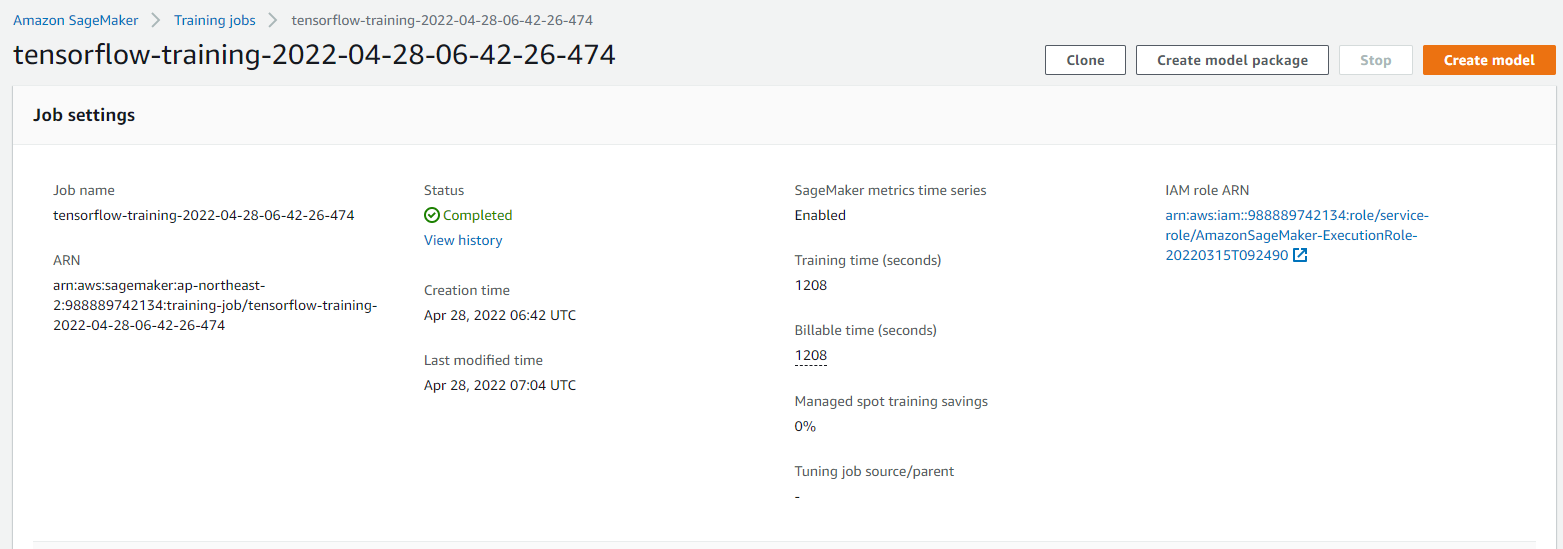

6. Deploy the trained model to an endpoint

In [10]:
predictor = mnist_estimator.deploy(
    initial_instance_count=1,
    instance_type='ml.m4.xlarge'
)

update_endpoint is a no-op in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


----!

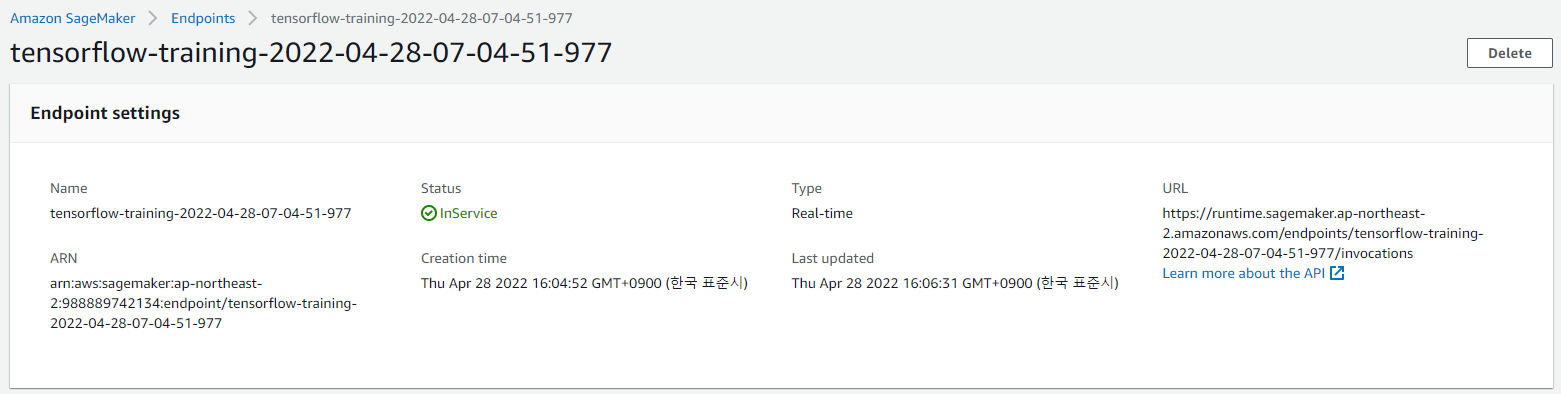

7. Invoke the endpoint

In [11]:
import numpy as np


!aws --region {region} s3 cp s3://sagemaker-sample-data-{region}/tensorflow/mnist/train_data.npy train_data.npy
!aws --region {region} s3 cp s3://sagemaker-sample-data-{region}/tensorflow/mnist/train_labels.npy train_labels.npy

train_data = np.load('train_data.npy')
train_labels = np.load('train_labels.npy')

download: s3://sagemaker-sample-data-ap-northeast-2/tensorflow/mnist/train_data.npy to ./train_data.npy
download: s3://sagemaker-sample-data-ap-northeast-2/tensorflow/mnist/train_labels.npy to ./train_labels.npy


8. Prediction

In [12]:
predictions = predictor.predict(train_data[:50])
for i in range(0, 50):
    prediction = predictions['predictions'][i]['classes']
    label = train_labels[i]
    print('prediction is {}, label is {}, matched: {}'.format(prediction, label, prediction == label))

prediction is 7, label is 7, matched: True
prediction is 3, label is 3, matched: True
prediction is 4, label is 4, matched: True
prediction is 6, label is 6, matched: True
prediction is 1, label is 1, matched: True
prediction is 8, label is 8, matched: True
prediction is 1, label is 1, matched: True
prediction is 0, label is 0, matched: True
prediction is 9, label is 9, matched: True
prediction is 8, label is 8, matched: True
prediction is 0, label is 0, matched: True
prediction is 3, label is 3, matched: True
prediction is 1, label is 1, matched: True
prediction is 3, label is 2, matched: False
prediction is 7, label is 7, matched: True
prediction is 0, label is 0, matched: True
prediction is 2, label is 2, matched: True
prediction is 9, label is 9, matched: True
prediction is 6, label is 6, matched: True
prediction is 0, label is 0, matched: True
prediction is 1, label is 1, matched: True
prediction is 6, label is 6, matched: True
prediction is 7, label is 7, matched: True
prediction

9. Delete the endpoint

In [15]:
predictor.delete_endpoint()